In [1]:
%load_ext autoreload
%autoreload 2

In [187]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import ShuffleSplit

import torch
from torch.utils.data import DataLoader
from torchinfo import summary

from spectral_ai import ScalogramData, ResNetModel, AlexNetModel

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Calc. embeddings

In [188]:
model = AlexNetModel()
summary(model, input_size=(100, 3, 600, 300))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNetModel                             [100, 9216]               --
├─Sequential: 1-1                        [100, 256, 6, 6]          --
│    └─Sequential: 2-1                   [100, 256, 17, 8]         --
│    │    └─Conv2d: 3-1                  [100, 64, 149, 74]        23,296
│    │    └─ReLU: 3-2                    [100, 64, 149, 74]        --
│    │    └─MaxPool2d: 3-3               [100, 64, 74, 36]         --
│    │    └─Conv2d: 3-4                  [100, 192, 74, 36]        307,392
│    │    └─ReLU: 3-5                    [100, 192, 74, 36]        --
│    │    └─MaxPool2d: 3-6               [100, 192, 36, 17]        --
│    │    └─Conv2d: 3-7                  [100, 384, 36, 17]        663,936
│    │    └─ReLU: 3-8                    [100, 384, 36, 17]        --
│    │    └─Conv2d: 3-9                  [100, 256, 36, 17]        884,992
│    │    └─ReLU: 3-10                   [100, 256, 36, 17]       

In [3]:
model = ResNetModel()
summary(model.model, input_size=(100, 3, 600, 300))

/mnt/cluster_vsbud-dl1-004/users/istvan.markusz/mambaforge/envs/colimo/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cluster_vsbud-dl1-004/users/istvan.markusz/mambaforge/envs/colimo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [100, 2048, 1, 1]         --
├─Conv2d: 1-1                            [100, 64, 300, 150]       9,408
├─BatchNorm2d: 1-2                       [100, 64, 300, 150]       128
├─ReLU: 1-3                              [100, 64, 300, 150]       --
├─MaxPool2d: 1-4                         [100, 64, 150, 75]        --
├─Sequential: 1-5                        [100, 256, 150, 75]       --
│    └─Bottleneck: 2-1                   [100, 256, 150, 75]       --
│    │    └─Conv2d: 3-1                  [100, 64, 150, 75]        4,096
│    │    └─BatchNorm2d: 3-2             [100, 64, 150, 75]        128
│    │    └─ReLU: 3-3                    [100, 64, 150, 75]        --
│    │    └─Conv2d: 3-4                  [100, 64, 150, 75]        36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 150, 75]        128
│    │    └─ReLU: 3-6                    [100, 64, 150, 75]        --
│ 

In [190]:
data = ScalogramData('/mnt/cluster_vsbud-dl1-004/hackathon/hackathon_wavelet', channels=['0', '1', '2'])
dataloader = DataLoader(data, batch_size=100, shuffle=False)

In [191]:
device = 'cuda'
model.eval()
model.to(device)

embeddings = []
for batch in tqdm(dataloader, total=len(dataloader)):
    
    batch = batch.to(device)
    
    with torch.no_grad():
        emb = model(batch)
        
    embeddings.append(emb.to('cpu'))
    
embeddings = torch.concat(embeddings)

  0%|          | 0/436 [00:00<?, ?it/s]

In [9]:
import pandas as pd
pd.Series(data.base_fnames).to_csv('emb_fnames.csv')

In [192]:
torch.save(embeddings, 'embeddings_alexnet.pt')

In [193]:
pca = PCA(0.99)
emb_reduced = pca.fit_transform(embeddings.numpy())
emb_reduced.shape

(43510, 3105)

# Analyze

In [194]:
META_PATH = "/mnt/cluster_vsbud-dl1-005/hackathon_meta/metadata.csv"
df_meta = pd.read_csv(META_PATH, index_col=0)
df_meta = df_meta[df_meta['DischargeTo_Agg'] != 'exitus']
df_meta.index = df_meta['file'].str.replace('.xml', '')

df_meta['EntryDate'] = pd.to_datetime(df_meta['EntryDate'])
df_meta['EntryTime'] = pd.to_datetime(df_meta['EntryTime'])
df_meta['EndDate'] = pd.to_datetime(df_meta['EndDate'])
df_meta['EndTime'] = pd.to_datetime(df_meta['EndTime'])

len(df_meta)

/tmp/ipykernel_43084/3044343676.py:6: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_meta['EntryDate'] = pd.to_datetime(df_meta['EntryDate'])
/tmp/ipykernel_43084/3044343676.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_meta['EntryTime'] = pd.to_datetime(df_meta['EntryTime'])
/tmp/ipykernel_43084/3044343676.py:8: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_meta['EndDate'] = pd.to_datetime(df_meta['EndDate'])
/tmp/ipykernel_43084/3044343676.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, p

33522

In [195]:
base_fnames = np.array(data.base_fnames)
is_labelled_filter = np.isin(base_fnames, df_meta.index)
labelled_fnames = base_fnames[is_labelled_filter]
labelled_embeddings = emb_reduced[is_labelled_filter]

In [196]:
def calc_scores(y_true, y_pred):
    
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    
    return {
        'acc': (tp + tn) / len(y_true),
        'prec': tp / (tp + fp),
        'spec': tn / (tn + fp),
        'sens': tp / (tp + fn),
    }

In [201]:
n_neighbors = 1

refit_iterations = 20
refit_neighbors = 1

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_meta.loc[labelled_fnames, 'DischargeTo_Agg'].values)
x = labelled_embeddings

outpatient_label = np.argmax(label_encoder.classes_ == 'outpatient')

clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
nn = NearestNeighbors(n_neighbors=refit_neighbors+1)
# clf = RadiusNeighborsClassifier(1.0)

scores = {}
df_predictions = pd.Series(np.nan, index=df_meta.index)
for i, (train_idx, test_idx) in tqdm(enumerate(ShuffleSplit(10, random_state=42).split(x)), total=10):
    
    x_train, y_train = x[train_idx], y[train_idx]
    
    for _ in range(refit_iterations):
        
        nn.fit(x_train)
        _, indices = nn.kneighbors(x_train)
        
        indices = indices[:, 1:]
        y_expected = np.repeat(y_train[:, np.newaxis], indices.shape[1], axis=1)
        
        bullshit_filter = (y_expected != y_train[indices]) & (y_train[indices] == outpatient_label)
        bullshit_indices = np.unique(indices[bullshit_filter])
        good_indices = ~np.isin(np.arange(len(x_train)), bullshit_indices)
        
        x_train, y_train = x_train[good_indices], y_train[good_indices]
        
    clf.fit(x_train, y_train)
    
    y_pred = clf.predict(x[test_idx])
    # y_pred = np.random.randint(3, size=len(test_idx))
    y_true = y[test_idx]
    
    for c in np.unique(y):
        scores[(i, c)] = calc_scores((y_true==c).astype(int), (y_pred==c).astype(int))
        
    df_predictions.loc[labelled_fnames[test_idx]] = y_pred
        
df_scores = pd.DataFrame(scores)

  0%|          | 0/10 [00:00<?, ?it/s]

In [202]:
# alexnet 10 refit 1
df_scores.T.groupby(level=1).mean().set_index(label_encoder.classes_)

,acc,prec,spec,sens
cardiology clinic,0.652043,0.395311,0.662397,0.622785
other,0.822756,0.206709,0.868403,0.352722
outpatient,0.607337,0.794687,0.743782,0.533798


In [199]:
# alexnet no refit
df_scores.T.groupby(level=1).mean().set_index(label_encoder.classes_)

,acc,prec,spec,sens
cardiology clinic,0.755145,0.536594,0.855476,0.471909
other,0.880197,0.307938,0.938231,0.282815
outpatient,0.710319,0.761637,0.531188,0.806850


In [136]:
# resnet 30 refit 2
df_scores.T.groupby(level=1).mean().set_index(label_encoder.classes_)

,acc,prec,spec,sens
cardiology clinic,0.531613,0.316469,0.478664,0.680974
other,0.773158,0.156824,0.813570,0.357168
outpatient,0.477811,0.771253,0.846226,0.279265


In [55]:
# random
df_scores.T.groupby(level=1).mean().set_index(label_encoder.classes_)

,acc,prec,spec,sens
cardiology clinic,0.577453,0.257664,0.666273,0.326782
other,0.642350,0.092696,0.671179,0.345992
outpatient,0.449866,0.647798,0.660161,0.336606


In [204]:
df_meta['y_pred'] = df_predictions
df_meta['y_true'] = label_encoder.transform(df_meta['DischargeTo_Agg'])

In [209]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33522 entries, MUSE_20231120_185341_83000 to MUSE_20231121_163641_17000
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   VentricularRate       33522 non-null  int64         
 1   AtrialRate            33522 non-null  int64         
 2   PRInterval            22291 non-null  float64       
 3   QRSDuration           33522 non-null  int64         
 4   QTInterval            33522 non-null  int64         
 5   QTCorrected           33522 non-null  int64         
 6   PAxis                 22019 non-null  float64       
 7   RAxis                 33522 non-null  int64         
 8   TAxis                 33522 non-null  int64         
 9   QRSCount              33522 non-null  int64         
 10  QOnset                33522 non-null  int64         
 11  QOffset               33522 non-null  int64         
 12  POnset                22165 non-n

ValueError: could not convert string to float: 'přes RZP/LSPP'

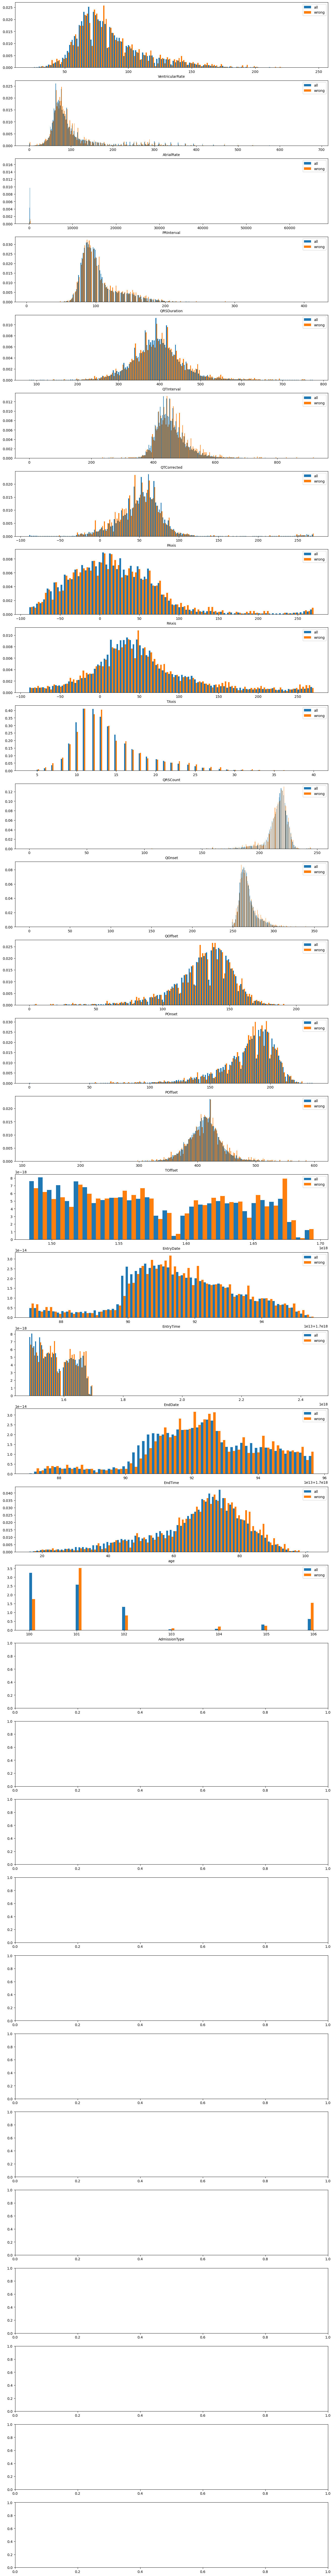

In [207]:
cols = [col for col in df_meta.columns if col not in ['patient_ID', 'visit_ID', 'SystolicBP', 'DiastolicBP', 'QTcFrederica', 'ECGSampleExponent', 'ECGSampleBase', 'file', 'AdmissionType_', "AdmissionRZP", "AdmissionRZP_", "DischargeTo_Agg", "DischargeTo_unit_agg", "VisitType_", "VisitReason_"]]

fig, axs = plt.subplots(len(cols), 1, figsize=(16, len(cols)*4))
for i, col in enumerate(cols):
    ax = axs[i]
    
    notna_filter = df_meta[col].notna()
    
    if col == 'DgCode':
        
        values = df_meta[col].str.extract(r"([A-Z])")
        
        outpatient_filter = (df_meta['y_pred'] == 2) & (df_meta['y_true'] != 2)
        values[outpatient_filter & notna_filter].hist(ax=ax, density=True, label='wrong')
        
        values[notna_filter].hist(ax=ax, density=True, label='all')
        
    else:
        
        hist, bin_edges = np.histogram(df_meta.loc[notna_filter, col].values.astype(float), bins='auto', density=True)
        width = np.diff(bin_edges)
        ax.bar(bin_edges[:-1], hist, width=width/2, align='edge', label='all')
        
        outpatient_filter = (df_meta['y_pred'] == 2) & (df_meta['y_true'] != 2)
        hist, bin_edges = np.histogram(df_meta.loc[outpatient_filter & notna_filter, col].values.astype(float), bins=bin_edges, density=True)
        ax.bar(bin_edges[:-1]+width/2, hist, width=width/2, align='edge', label='wrong')
        
    ax.set_xlabel(col)
    ax.legend()
    
plt.show()